# Final assignment of “Management and Analysis of Physics Datasets” 
## Session I
### Anna Braghetto - 1205200 and Theosamuele Signor - 1212253


### Part A 

In order to perform the analysis we follows two different approaches. At first, we used our local Unix machine and then we repeated the whole procedure using the VirtualMachine offered by CloudVeneto.it. The results obtained are then compared.<br>
The commands used are the same for both local and remote machine, except for the login to the Cloud. 

We first log in the CloudVeneto gate with our username,

    ssh USERNAME@gate.cloudveneto.it
    
accessed a machine as root

    ssh root@10.67.22.26
    
and then became user.

    ssh USERNAME
    
Then, for both machine, we installed REDIS and we lauched a server with:

    ./redis-server &

Finally, we added a new path variable

    export PATH=/tmp/redis-5.0.5/src:$PATH
     

### Part B - Implementation of _cloud.sh_ library

As requested we created a 1kB file using following the command:

    dd if=/dev/zero of=/tmp/output.dat  bs=1k  count=1

To load an arbitrary number of this file with different names, we defined the following function:

    function cloud_items() {
        #reinitialize redis database
        redis-cli -h `hostmap 1` -p `portmap 1` -n `dbmap 1` FLUSHALL 
        #upload the file
        #$1 is the file; $2 number of times we upload $1 
    for ((i=1;i<=$2;i++)); do cloud_upload $1 `uuidgen`; done   
    }
    
Which is called via:

    cloud_items output.dat number_of_iterations
    

### Part C - Comparison among different number of uploaded files

As requested we upload different number of files: 100, 500, 1000, 5000, 10000, 100000.
To accomplish this task we used the function __cloud_items()__ (defined above) by changing the second argument, which is the wanted number of uploaded file.

Then, we measured the execution time for the __cloud_ls()__ function with:

    time cloud_ls
    
For the Cloud, in order to have results that are not affected by the connession, the times are stores in a _.txt_ cloud file.
    

To begin our data analysis, at first we import the required packages

In [1]:
import numpy as np
np.random.seed(123456789)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
import numpy as np
np.random.seed(123456789)
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score

In [2]:
#linear regression
def linear_regression(t,N):    
    rect = linear_model.LinearRegression()
    rect.fit(N.reshape(-1,1), t)
    timeP = rect.predict(np.arange(0,N[-1]).reshape(-1,1))
    r = r2_score(t, rect.predict(N.reshape(-1,1)))  #r-value for regression
    return(timeP,np.sqrt(r))

In [3]:
N = np.array([100,500,1000,5000,10000,100000])                  #numbers of files
time = np.array([0.042, 0.045, 0.062, 0.094, 0.145, 1.109])     #local times 
time_cloud=np.array([0.049, 0.048, 0.059, 0.102, 0.137,1.306])  #cloud times

timeP,r = linear_regression(time,N)
timeP_cloud,r_cloud = linear_regression(time_cloud,N)

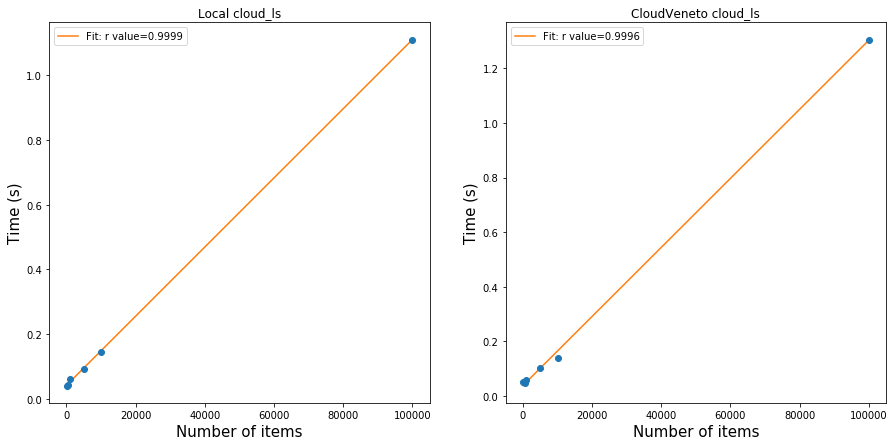

In [4]:
# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.set_xlabel('Number of items', fontsize=15)
ax1.set_ylabel('Time (s)', fontsize=15)
ax1.plot(np.arange(0,100000),timeP, '-', markersize=12, c='C1',label='Fit: r value=%0.4f'%r)
ax1.plot(N,time, '.', markersize=12)
ax1.set_title('Local cloud_ls')
ax1.legend()

ax2.set_xlabel('Number of items', fontsize=15)
ax2.set_ylabel('Time (s)', fontsize=15)
ax2.plot(np.arange(0,100000),timeP_cloud, '-', markersize=12, c='C1',label='Fit: r value=%0.4f'%r_cloud)
ax2.plot(N,time_cloud, '.', markersize=12)
ax2.set_title('CloudVeneto cloud_ls')
ax2.legend();

The results obtained for our local machine and the CloudVeneto remote one are really similar: there are no performance differences between machines.<br>
Therefore, on both the machines, as shown in the graphs above, the listing function, implemented in __cloud_ls()__ is not scalable. In fact, the execution time increases linearly as the number of uploaded files increases. To show this behaviour we also perfomed a linear regression on the data and we observe how the values formed a straight line: the r-_value_ is almost 1 for both machines.

Furthermore, we intepret the slope of the straight as a measure of scalability of the function: higher values are associated to worse scalability.
The slopes values are collected in the table below.


|Slope for local|Slope for remote|
|---------------|----------------|
|1.06 $\cdot$ 10$^{-5}$ s|1.27 $\cdot$ 10$^{-5}$ s|

As shown in the graphs, the slopes are really similar. We also computed the errors of the slopes and they are of the order of 10$^{-9} s$.


### Part D - One million uploads

We now upload 1000000 items with the function __cloud_1M__, defined below, which permits, not only to store the one million files, but also to record in a file the needed time for each upload: this allows to study the scaling of the function.

    function cloud_1M(){
        #reinitialize redis database
        redis-cli -h `hostmap 1` -p `portmap 1` -n `dbmap 1` FLUSHALL 
        #upload of the files
        #$1 is the file; $2 number of times we upload $1 
    for ((i=1;i<=1000000;i++))
        do 
            time (cloud_upload $1 `uuidgen`) >> ~/Desktop/times.dat 2>&1
            done
    }

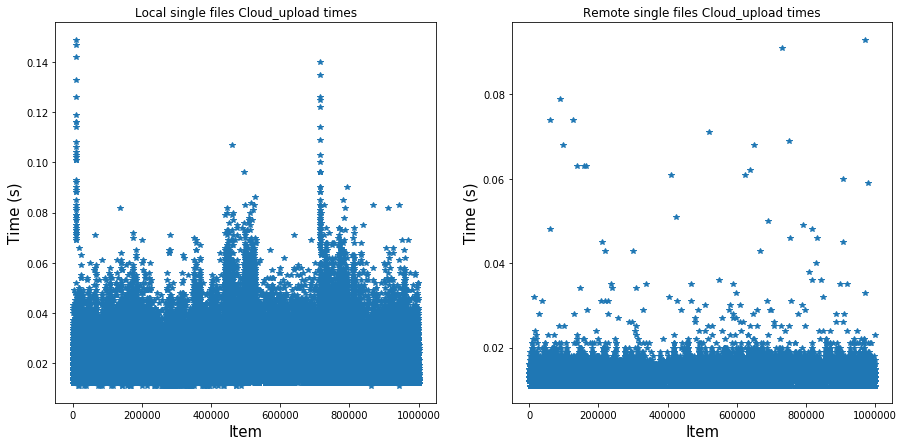

In [5]:
#read the file containing the values
data = pd.read_csv("times.dat",sep='\t',header=None) 
data_cloud = pd.read_csv("times_cloud.dat",sep='\t',header=None) 

data=data[data[0]=='real']
data=data.drop([0], axis=1)
data.columns = ['m', 's']

data_cloud=data_cloud[data_cloud[0]=='real']
data_cloud=data_cloud.drop([0], axis=1)
data_cloud.columns = ['m', 's']

#plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.set_xlabel('Item', fontsize=15)
ax1.set_ylabel('Time (s)', fontsize=15)
ax1.plot(np.arange(1,1000001),data['m']/60+data['s'], '*')
ax1.set_title('Local single files Cloud_upload times')

ax2.set_xlabel('Item', fontsize=15)
ax2.set_ylabel('Time (s)', fontsize=15)
ax2.plot(np.arange(1,1000001),data_cloud['m']/60+data_cloud['s'], '*')
ax2.set_title('Remote single files Cloud_upload times');

On the left graph we observe the upload times obtained in our local machine, while on the right, there are the results for the remote one. Immediatly we notice a difference on the behaviour: on our machine the times are within a larger range and there are some visible peaks. This difference is explained by background processes which run during the upload of the files on our machine. These kind of processes are not manageable, so we cannot obtain better results even if we repeat the precedure. While, on the remote machine, there are not any background processes that distorts the real upload time, in fact the distribution is more uniform without peaks.<br>
However, since, for both our local machine and the remote one, the times do not increase as the \# iteration increases and, in general, do not follow a increasing behaviour, the upload function is scalable.<br>

Then, we apply the function __cloud_ls()__ and we study its performance with 1000000 items.


At first, we try to infere the execution time of the function for 1000000 files through the linear regression found in __Part C__ and we compare it with the real performance. Then, add to the first plot in __Part C__ this execution time and we show the difference in the behaviour.

In [6]:
#infere
rect = linear_model.LinearRegression()
rect.fit(N.reshape(-1,1), time)
time1M = rect.predict(np.array(1000000).reshape(-1,1))
print('LOCAL: The expected execution time is: %0.3f' %time1M[-1], 's, while the real execution time is: 12.291 s.')


rect_cloud = linear_model.LinearRegression()
rect_cloud.fit(N.reshape(-1,1), time_cloud)
time1M_cloud = rect_cloud.predict(np.array(1000000).reshape(-1,1))
print('CLOUD: The expected execution time is: %0.3f' %time1M_cloud[-1], 's, while the real execution time is: 13.782 s.')

LOCAL: The expected execution time is: 10.706 s, while the real execution time is: 12.291 s.
CLOUD: The expected execution time is: 12.697 s, while the real execution time is: 13.782 s.


In [7]:
N = np.array([100,500,1000,5000,10000,100000,1000000])
time = np.array([0.042, 0.045, 0.062, 0.094, 0.145, 1.109, 12.291])
time_cloud=np.array([0.049, 0.048, 0.059, 0.102, 0.137,1.406,13.782])      #cloud times

timeP, r = linear_regression(time,N)
timeP_cloud, r_cloud = linear_regression(time_cloud,N)

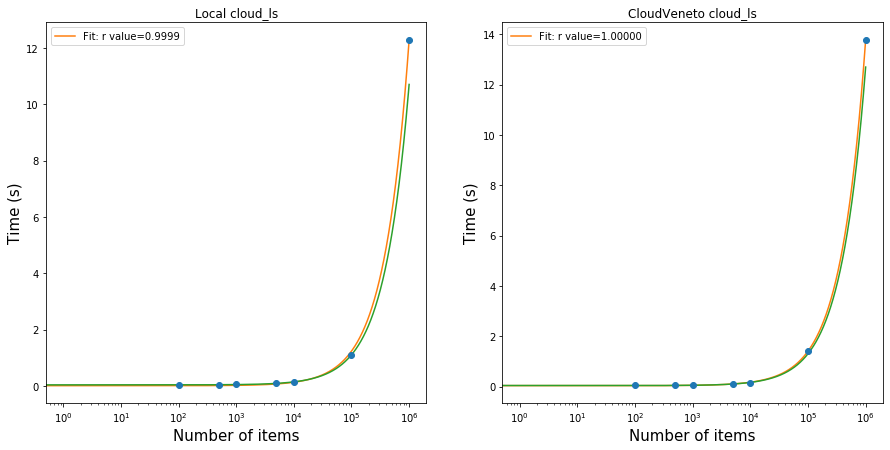

In [8]:
# plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.set_xscale('log')
ax1.set_xlabel('Number of items', fontsize=15)
ax1.set_ylabel('Time (s)', fontsize=15)
ax1.plot(np.arange(0,1000000),timeP, '-', markersize=12, c='C1',label='Fit: r value=%0.4f'%r)
ax1.plot(np.arange(0,1000000),rect.predict(np.arange(0,1000000).reshape(-1,1)), '-', markersize=12, c='C2')
ax1.plot(N,time, '.', markersize=12);

ax2.set_xscale('log')
ax2.set_xlabel('Number of items', fontsize=15)
ax2.set_ylabel('Time (s)', fontsize=15)
ax2.plot(np.arange(0,1000000),timeP_cloud, '-', markersize=12, c='C1',label='Fit: r value=%0.5f'%r_cloud)
ax2.plot(np.arange(0,1000000),rect_cloud.predict(np.arange(0,1000000).reshape(-1,1)), '-', markersize=12, c='C2')
ax2.plot(N,time_cloud, '.', markersize=12)

ax1.set_title('Local cloud_ls')
ax1.legend(loc='best')
ax2.set_title('CloudVeneto cloud_ls')
ax2.legend(loc='best');

We observe, in both cases, that the performance of the listing function in __cloud_ls()__ is still linear with respect to the number of items, in fact the r-_value_ of the linear fit is almost 1. In particular we notice that the slope of the straight line computed considering the 1000000 items time, increases slightly with respect to the one computed in __Part C__: this is due to the fact that the points are not perfectly alligned, indeed the r-_value_ is not 1.

The value of the slopes are collected in the table below.

|Slope for local|Slope for remote|
|---------------|----------------|
|1.23 $\cdot$ 10$^{-5}$ s|1.37 $\cdot$ 10$^{-5}$ s|


The slopes change a little bit and the errors are the same orders found without 1000000 items: order of 10$^{-9}$ s.

### Part E

#### Bucket
By using the Bucket we expect that the listing is faster because we do not need to iterate on the REDIS database, but just one access to it is sufficient.

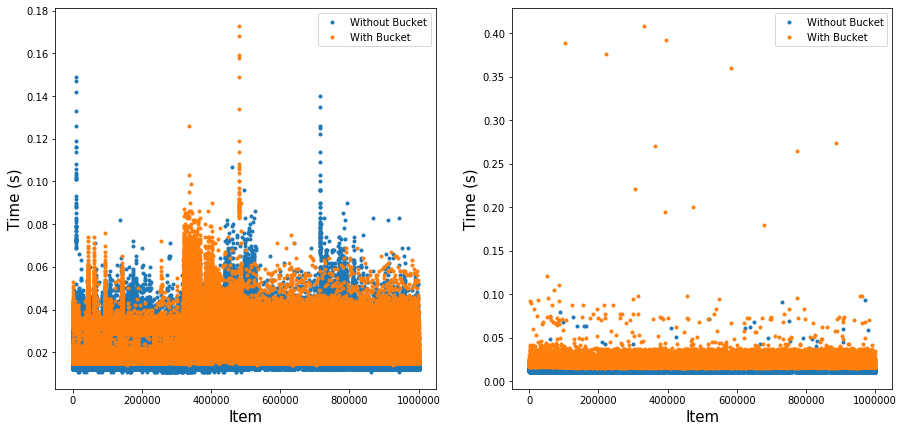

In [9]:
#read the file containing the values
data_bucket = pd.read_csv("times_bucket.dat",sep='\t',header=None) 
data_bucket_cloud = pd.read_csv("times_bucket_cloud.dat",sep='\t',header=None) 


data = pd.read_csv("times.dat",sep='\t',header=None) 
data_cloud = pd.read_csv("times_cloud.dat",sep='\t',header=None) 

data=data[data[0]=='real']
data=data.drop([0], axis=1)
data.columns = ['m', 's']
data_bucket=data_bucket[data_bucket[0]=='real']
data_bucket=data_bucket.drop([0], axis=1)
data_bucket.columns = ['m', 's']

data_cloud=data_cloud[data_cloud[0]=='real']
data_cloud=data_cloud.drop([0], axis=1)
data_cloud.columns = ['m', 's']
data_bucket_cloud.columns = ['m','s']

#plot
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))

ax1.set_xlabel('Item', fontsize=15)
ax1.set_ylabel('Time (s)', fontsize=15)
ax1.plot(np.arange(1,1000001),data['m']/60+data['s'], '.', label='Without Bucket')
ax1.plot(np.arange(1,1000001),data_bucket['m']/60+data_bucket['s'], '.', label='With Bucket' )
ax1.legend(loc='best');


ax2.set_xlabel('Item', fontsize=15)
ax2.set_ylabel('Time (s)', fontsize=15)
ax2.plot(np.arange(1,1000001),data_cloud['m']/60+data_cloud['s'], '.', label='Without Bucket')
ax2.plot(np.arange(1,1000001),data_bucket_cloud['m']/60+data_bucket_cloud['s'], '.', label='With Bucket' )
ax2.legend(loc='best');

As in the analysis without bucket, for the local machine many peaks are visible due to background processes, while they are not present in the remote one.

For both local and remote, as expected we observe a shift on the upload time, due to the bucket filling. Neverthless the increase of time, the  distribution is still uniform. This behavior shows the scalability of the function also using the bucket.

In order to show better that the distribution is uniform we also plot the histogram for the results obtained with the remote machine.

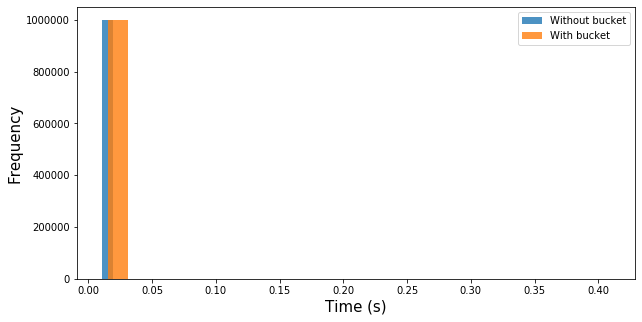

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(data_cloud['s'], bins=10, alpha=0.8, label='Without bucket')
ax.hist(data_bucket_cloud['s'],bins=25,alpha=0.8,label='With bucket')
ax.set_xlabel('Time (s)',fontsize=15)
ax.set_ylabel('Frequency',fontsize=15)
ax.legend(loc='best');

As expected there are two peaks that shows that the distribution is uniform.

Now we look at how the scalability of the cloud_ls function changes

In [16]:
N = np.array([100,500,1000,5000,10000,100000,1000000])

time = np.array([0.042, 0.045, 0.062, 0.094, 0.145, 1.109,12.291])                    #local times
time_bucket = np.array([0.006, 0.007,0.013, 0.042,0.057,0.870,10.053])                #bucket local times
time_cloud=([0.049, 0.048, 0.059, 0.102, 0.137,1.306, 13.782])                        #cloud times
time_bucket_cloud=np.array([0.006,0.007,0.08,0.023,0.05,0.828,10.925])                #bucket cloud times

In [17]:
#linear regression
timeP, r = linear_regression(time,N)
timePB, rB = linear_regression(time_bucket,N)
timeP_cloud, r_cloud = linear_regression(time_cloud,N)
timePB_cloud, rB_cloud = linear_regression(time_bucket_cloud,N)

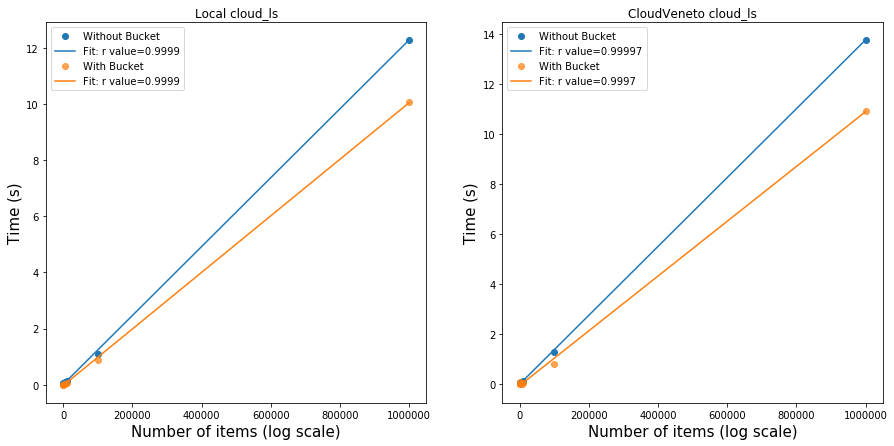

In [19]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(15,7))
# ax1.set_xscale('log')
ax1.set_xlabel('Number of items (log scale)', fontsize=15)
ax1.set_ylabel('Time (s)', fontsize=15)
ax1.plot(N,time, '.', markersize=12, label='Without Bucket');
ax1.plot(np.arange(0,1000000),timeP, '-', markersize=12, c='C0',label='Fit: r value=%0.4f'%r)
ax1.plot(N,time_bucket, '.', markersize=12, alpha=0.7, label='With Bucket')
ax1.plot(np.arange(0,1000000),timePB, '-', markersize=12, c='C1',label='Fit: r value=%0.4f'%rB)


ax2.set_xlabel('Number of items (log scale)', fontsize=15)
ax2.set_ylabel('Time (s)', fontsize=15)
ax2.plot(N,time_cloud, '.', markersize=12, label='Without Bucket')
ax2.plot(np.arange(0,1000000),timeP_cloud, '-', markersize=12, c='C0',label='Fit: r value=%0.5f'%r_cloud)
ax2.plot(N,time_bucket_cloud, '.', markersize=12, alpha=0.7, label='With Bucket')
ax2.plot(np.arange(0,1000000),timePB_cloud, '-', markersize=12, c='C1',label='Fit: r value=%0.4f'%rB_cloud)

ax1.set_title('Local cloud_ls')
ax1.legend(loc='best')
ax2.set_title('CloudVeneto cloud_ls')
ax2.legend(loc='best');


As observed without usign the bucket, there are no visible difference between the results obtained using the local and the remote machine.<br>
In both case, as expected, by using the bucket we observe that the execution time for the the listing is smaller with respect to the one obtained without the bucket, indeed the slope of the orange straight lines (with bucket) is smaller than the blue ones (without bucket) as shown in the table.


|Slope wo Bucket|Slope w Bucket|$\leftarrow$Local and Remote $\rightarrow$|Slope wo Bucket (s)|Slope w Bucket(s)|
|--------|--------|--------|--------|--------|
|1.22 $\cdot$ 10$^{-5}$ s|1.00 $\cdot$ 10$^{-5}$ s||1.37 $\cdot$ 10$^{-5}$ s|1.09 $\cdot$ 10$^{-5}$ s|

As said above, since an higher slope represents a worse scalibity, the introduction of the bucket permits to have an improvement on the scalibility of the function cloud_ls. Neverthless the improvement the funcion is still not scalable. 

#### Authentication
If we implemented security and for each called function we wanted the authentication, we would expect that the needed time increases but we do not expect that this affects the scaling: __cloud_upload()__ would be still scalable while __cloud_ls()__ would not.

To reduce the impact of the delay due to the authentication, we would make a time authetication. In this way the authentication is required at the first call and it is required again not for all the other calls, but after an arbitrary time such as half an hour.


#### Redundancy

To reduce the probability of data loss, e.g. due to the break up of one or more servers, we would make replicas of the files. 
To accomplish this task we need to define _hashneighbours_ : we store the replicas in the server defined by these values. For example, if a namefile has _hashvalue_ equal to 6, the _hashneighbours_ are 5 and 7: the file is uploaded in server 6, and its replicas are uploaded in servers 5 and 7.
In this way, if server 6 breaks up, we have a copy of the file in both servers 5 and 7: the data are not lost.<br>
The choice on the retrieved file depends on how the database is balanced.
For homogeneous ones, the choice has to be random: we are not interested in which servers the file comes from, while, if the database is not well balanced, the choice depends on the specific server hardware.

From the hardware point of view, it is possible to implement some level of RAID technology, dependently on the avalaible resources.
